# Import libraries

In [1]:
!pip install rake-nltk

     |████████████████████████████████| 1.5 MB 1.7 MB/s 
     |████████████████████████████████| 749 kB 38.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from rake_nltk import Rake
import operator

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data

In [3]:
train_original = pd.read_csv('/content/drive/MyDrive/Kaggle/train.csv')
train_original.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
train = train_original[:1000]
train.shape

(1000, 9)

In [5]:
train = train[['ID', 'TITLE',	'ABSTRACT']]
train.head()

,ID,TITLE,ABSTRACT
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...


In [6]:
train['ABSTRACT'] = train['ABSTRACT'].apply(lambda x:x.replace('\n', ' '))

In [7]:
train['TEXT'] = train['TITLE'] + train['ABSTRACT']

In [8]:
train['TEXT'][0]

"Reconstructing Subject-Specific Effect Maps  Predictive models allow subject-specific inference when analyzing disease related alterations in neuroimaging data. Given a subject's data, inference can be made at two levels: global, i.e. identifiying condition presence for the subject, and local, i.e. detecting condition effect on each individual measurement extracted from the subject's data. While global inference is widely used, local inference, which can be used to form subject-specific effect maps, is rarely used because existing models often yield noisy detections composed of dispersed isolated islands. In this article, we propose a reconstruction method, named RSM, to improve subject-specific detections of predictive modeling approaches and in particular, binary classifiers. RSM specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers. The proposed method is a wrapper-type algorithm that can be used with differen

In [9]:
train.drop(['TITLE', 'ABSTRACT'], axis=1, inplace=True)
train.head()

,ID,TEXT
0,1,Reconstructing Subject-Specific Effect Maps P...
1,2,Rotation Invariance Neural Network Rotation i...
2,3,Spherical polyharmonics and Poisson kernels fo...
3,4,A finite element approximation for the stochas...
4,5,Comparative study of Discrete Wavelet Transfor...


# Text Cleaning

In [10]:
from nltk.corpus import stopwords

In [11]:
def clean_text(i):
  text = re.sub("[^a-zA-Z0-9]"," ",i)
  text = text.lower()
  text = text.split()
  text = [word for word in text if word not in stopwords.words('english')]
  text = " ".join(text)
  return text


In [12]:
train['clean'] = train['TEXT'].apply(lambda i: clean_text(i))

In [13]:
train.head()

,ID,TEXT,clean
0,1,Reconstructing Subject-Specific Effect Maps P...,reconstructing subject specific effect maps pr...
1,2,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation in...
2,3,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics poisson kernels polyha...
3,4,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...


In [14]:
import spacy
en_core = spacy.load('en_core_web_sm')

In [15]:
train["lemmatized"] = train['clean'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))

In [16]:
train.head()

,ID,TEXT,clean,lemmatized
0,1,Reconstructing Subject-Specific Effect Maps P...,reconstructing subject specific effect maps pr...,reconstruct subject specific effect map predic...
1,2,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation in...,rotation invariance neural network rotation in...
2,3,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics poisson kernels polyha...,spherical polyharmonic poisson kernel polyharm...
3,4,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,comparative study discrete wavelet transform w...


In [ ]:
corpus = train['lemmatized'].values

# Vectorizing

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vector = TfidfVectorizer(stop_words={'english'}) # We remove the stopword prior to vectorizing
X = vector.fit_transform(corpus)

# Clustering

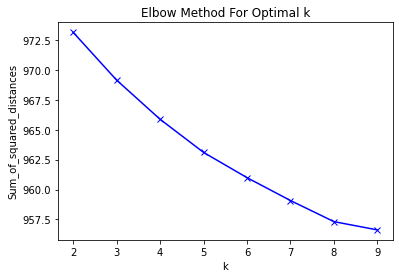

In [20]:
Sum_of_squared_distances = []
K = range(2, 10)

for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)

# Plotting   
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [21]:
# A list holds the silhouette coefficients for each k
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

for k in range(2, 11):                                        # you start at 2 clusters for silhouette coefficient instead of 1
    kmeans = KMeans(n_clusters=k, max_iter=200, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

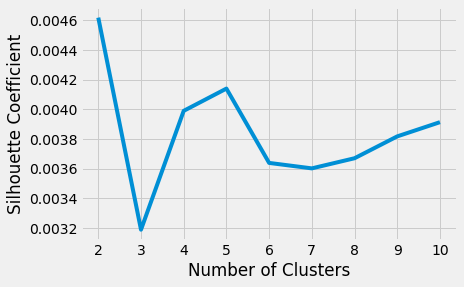

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [23]:
!pip install kneed

In [24]:
from kneed import KneeLocator
kl = KneeLocator(
    range(2, 10), Sum_of_squared_distances, curve="convex", direction="decreasing"
)

kl.elbow

5

In [25]:
k = kl.elbow
model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_

In [26]:
len(labels)

1000

In [27]:
train['cluster_no'] = labels
train.head()

,ID,TEXT,clean,lemmatized,cluster_no
0,1,Reconstructing Subject-Specific Effect Maps P...,reconstructing subject specific effect maps pr...,reconstruct subject specific effect map predic...,4
1,2,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation in...,rotation invariance neural network rotation in...,1
2,3,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics poisson kernels polyha...,spherical polyharmonic poisson kernel polyharm...,2
3,4,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,finite element approximation stochastic maxwel...,0
4,5,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,comparative study discrete wavelet transform w...,1


In [35]:
# Generate the grouped/labelled csv file
for i in range(k):
  df_i = train[train['cluster_no']==i]
  csv_name = 'label_' + str(i) + '.csv'
  df_i.to_csv(csv_name)